# Homework 5: Boosting and PCA

This assignment is due on Canvas by **11:59pm on Friday April 16**. 
Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.
Your solutions to computational questions should include any specified Python code and results 
as well as written commentary on your conclusions.
Remember that you are encouraged to discuss the problems with your instructors and classmates, 
but **you must write all code and solutions on your own**. For a refresher on the course **Collaboration Policy** click [here](https://github.com/akkikiki/CSCI-4622-Machine-Learning-sp21/blob/main/info/syllabus.md#collaboration-policy).

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda (Version: 2019.07) with Python 3.7. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc.
- **Unzip the files in data folder**


**Please put your name and cuidentity username.**

**Name**: Rees LaBree

**Identity Key**: rela3138

In [1]:
import math
import pickle
import gzip
import numpy as np
import pandas
import matplotlib.pylab as plt
%matplotlib inline

# Set random state for all sklearn functions
np.random.seed(0)

[40 points] Problem 1 - Principal Component Analysis
---

In this problem you'll be implementing Dimensionality reduction using Principal Component Analysis technique. 

The gist of PCA Algorithm to compute principal components is follows:
- Calculate the covariance matrix X of data points.
- Calculate eigenvectors and corresponding eigenvalues.
- Sort the eigenvectors according to their eigenvalues in decreasing order.
- Choose first k eigenvectors which satisfies target explained variance.
- Transform the original n dimensional data points into k dimensions.

The skeleton for the `PCA` class is below. Scroll down to find more information about your tasks as well as unit tests.

In [2]:
class PCA:
    def __init__(self, target_explained_variance=None):
        """
        explained_variance: float, the target level of explained variance
        """
        self.target_explained_variance = target_explained_variance
        self.feature_size = -1

    def standardize(self, X):
        """
        standardize features using standard scaler
        :param m X n: features data
        :return: standardized features
        """
        return (X - np.mean(X))/np.std(X)

    def compute_eigen_vector(self, cov_mat):
        """
        Eigenvector and eigen values using numpy
        :param cov_mat:
        :return: (eigen_vector,eigen_values)
        """
        return np.linalg.eig(cov_mat)

    def compute_explained_variance(self, eigen_vals):
        """
        sort eigen values and compute explained variance.
        explained variance informs the amount of information (variance)
        can be attributed to each of  the principal components.
        :param eigen_vals:
        :return: explained variance.
        """
        return np.sort(eigen_vals)[::-1] / sum(eigen_vals)

    def cumulative_sum(self, var_exp):
        """
        return cumulative sum of explained variance.
        :param var_exp: explained variance
        :return: cumulative explained variance
        """
        return np.cumsum(var_exp)

    def compute_weight_matrix(self, eig_pairs, var_exp):
        """
        compute weight matrix of top principal components conditioned on target
        explained variance.
        Hint : 
            use cumulative explained variance and target_explained_variance 
            to find top components
        
        :param eig_pairs: list of tuples containing eigenvector and eigen values
        :param var_exp: *sorted* explained variance proportions, by features
        :return: weight matrix
        """
        eig_vects = 0
        for i, j in enumerate(self.cumulative_sum(var_exp)):
            if j >= self.target_explained_variance:
                eig_vects = i
                break
        
        return np.transpose(eig_pairs[1][:eig_vects])

    def transform_data(self, X_std, matrix_w):
        """
        transform data to subspace using weight matrix
        :param X_std: standardized data
        :param matrix_w: weight matrix
        :return: data in the subspace
        """
        return X_std.dot(matrix_w)

    def fit(self, X):
        """
        entry point to the transform data to k dimensions
        standardize and compute weight matrix to transform data.
        Hint:
            use np.cov(X_std.T) to get the covariance matrix (n X n matrix)
        :param   m X n dimension: train samples
        :return  m X k dimension: subspace data.
        """
    
        self.feature_size = X.shape[1]
        
        # code
        X_std = self.standardize(X)
        cov_mat = np.cov(X_std.T)
        eigen_pairs = self.compute_eigen_vector(cov_mat)
        exp_var = self.compute_explained_variance(eigen_pairs[0])
        matrix_w = self.compute_weight_matrix(eigen_pairs, exp_var)
        
        
        return self.transform_data(X_std=X_std, matrix_w=matrix_w)


### Part 1 [20 points]
Your task involves implementing helper functions to compute mean, 
covariance, eigenvector and weights.

Complete `fit` to use all helper functions to find reduced dimension data.

In [15]:
from tests import tests
tests.run_test_suite("prob 1", PCA)

TestReducedShape (tests.tests.TestPCA) ... ok
TestExplainedVariance (tests.tests.TestPCA) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


### Part 2 [5 points] Run PCA on fashion mnist dataset to reduce the dimension of the data.

fashion mnist data consists of samples with 784 dimensions.

Report the reduced dimension $k$ for target explained variance of **0.99**

**Note: You need to unzip the data used below (you might need to install some packages)**

We've added a command to perform this operation directly from the notebook, but note you're milage here may vary. If it doesn't work, you might need to install some packages for your OS accordingly. 

In [16]:
# unzip the data
#!tar -xvf data/fashion-mnist.tar.bz2 -C data

# now you can load the data
X_train = pickle.load(open('./data/mnist/train_images.pkl','rb'))
y_train = pickle.load(open('./data/mnist/train_image_labels.pkl','rb'))
X_train = X_train[:15000]
y_train = y_train[:15000]

In [17]:
a = PCA(.99)

X_train_updated = a.fit(X_train)
print(X_train_updated.shape, X_train.shape)

(15000, 451) (15000, 784)


### Part 3 [5 points]
Run scikit-learn SVM Classifier (refer to previous homework) on the reduced dimension data with approrpiate kernel and C.

Report the accuracy on test dataset.

In [18]:
from sklearn.model_selection import train_test_split
X_t, X_test, y_t, y_test = train_test_split(
    X_train_updated, y_train, test_size=0.2, random_state = 5622)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm = make_pipeline(StandardScaler(), SVC(C=.5 , kernel='rbf', gamma='auto'))
svm.fit(X_t,y_t)
print(svm.score(X_test, y_test))

### Part 4 [10 points]
Repeat the same experiment for different values of target explained variance between: **[0.8-1.0]** with increments of $0.04$, provide the reduced dimension size for each, and then:

- Plot the graph of accuracy vs target explained variance.
- Plot the graph of the number of components vs target explained variance.

In [8]:
# In the following lists, store for each experiment:
#    target variance, number of components, accuracy
# These are to be used in plotting next
target_explained_variances = []
numbers_of_components = []
accuracies = []
for target_variance in np.arange(0.8, 1.0, .04):
    a = PCA(target_variance)
    X_train_updated = a.fit(X_train)
    X_t, X_test, y_t, y_test = train_test_split(
    X_train_updated, y_train, test_size=0.2, random_state = 5622)
    svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    svm.fit(X_t,y_t)
    target_explained_variances.append(target_variance)
    numbers_of_components.append(X_train_updated[1].shape)
    accuracies.append(svm.score(X_test, y_test))
    
print(target_explained_variances, numbers_of_components, accuracies)

[0.8, 0.8400000000000001, 0.8800000000000001, 0.9200000000000002, 0.9600000000000002] [(23,), (37,), (62,), (111,), (222,)] [0.7853333333333333, 0.8003333333333333, 0.8293333333333334, 0.8416666666666667, 0.855]


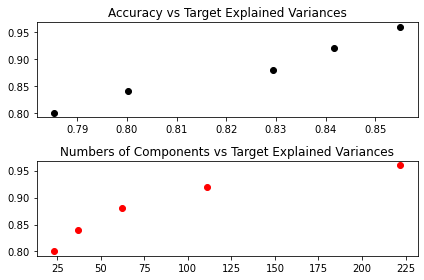

In [111]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.title.set_text('Accuracy vs Target Explained Variances')
ax2.title.set_text('Numbers of Components vs Target Explained Variances')

for i in range(len(target_explained_variances)):
    ax1.plot(accuracies[i],target_explained_variances[i], 'o', color='black')

for i in range(len(target_explained_variances)):
    ax2.plot(numbers_of_components[i],target_explained_variances[i], 'o', color='red')
    
fig.tight_layout()

Discuss your observations below.

Accuracy is positively correlated with target explained variance. As we increase variance, our updated data set includes more points. With the addition of new points, it seems likely that the increase in training data would cause the accuracy to increase.

[20 points] Problem 2 - Statistical PCA for non-zero mean random variables. 
---
Let $x \in R^D$ be a random vector. Let $\mu_x$ and $C_x$ be mean and covariance of x respectivley. 

We define *Principal components* of $x$ as $v_i$. Assuming that the eigenvalues of $C_x$ are different from each other

show that

1) $v_1$ is the eigenvector of $C_x$ corresponding to its largest eigenvalue.

2) $v_2^T v_1$ = 0 and $v_2$ is the eigenvector of $C_x$ corresponding to its second largest eigenvalue.

$$
2C_Xw - 2\lambda w = 0 \\
C_X = \lambda \\
$$
This takes the form that $\lambda$ is an eigen value of C.
We compute the principal components by computing and removing the largest principle component from the data set. This process is repeated iteratively, leading to the principle components being stored from largest to smallest in series. From the above derivation we show that principle components are equivalent to eigenvalues of $C_X$, and as such the first principle component $v_1$ is equivalent to the largest eigenvalue of $C_x$.

[40 points] Problem 3  - Decision Tree Ensembles: Bagging and Boosting
---

We are going to predict house price using decision tree ensembles.

In this Regression problem, we compare Decision trees and it's ensembles - bagging and Boosting on House Price prediction dataset : https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Make use standard Regression API's of  Decision tree ensembles from sklearn to predict the house price. http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

### Part 1 [20 points]
Complete the `EnsembleTest` class to fit appropriate model recieved as parameter and store the test accuracy. This class allows us to aggregate results from multiple experiments of the same type (Regression or Classification) and report results for easier comparison.

Later we will use `EnsembleTest` class to plot score, metric and time taken to fit the data.

In [86]:
from time import time
from sklearn.metrics import explained_variance_score, precision_score
import pandas as pd


class EnsembleTest:
    """ Test multiple model performance """
    
    def __init__(self, X_train, y_train, X_test, y_test, _type='regression'):
        """
        initialize data and type of problem
        :param X_train:
        :param y_train:
        :param X_test:
        :param y_test:
        :param _type: regression or classification
        """
        self.scores = {}
        self.execution_time = {}
        self.metric = {}
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.type = _type
        if _type == 'regression':
            self.score_name = 'R^2 score' 
            self.metric_name = 'Explained variance' 
        else:
            self.score_name = 'Mean accuracy score'
            self.metric_name = 'Precision'
            
    def fit_model(self, model, name):
        """
        TODO:
        - Fit the model on train data.
        - Store execution time required to fit.
        - Store scores on test data
        - Predict on test data
        
        Each model passed as parameter has member functions of the following form:
          model.fit(x_train, y_train)
          model.score(x_test, y_test) 
          model.predict(x_test)
        
        :param model: model
        :param name: name of model
        """
        s = time()
        model.fit(self.X_train, self.y_train)
        e = time()
        
        self.execution_time[name] = (e - s)
        
        self.scores[name] = model.score(self.X_test, self.y_test) 
        
        predict = model.predict(self.X_test)
        
        if self.type == 'regression':
            self.metric[name] = explained_variance_score(self.y_test, predict)
        elif self.type == 'classification':
            self.metric[name] = precision_score(self.y_test, predict)

    def print_result(self):
        """
            print results for all models trained and tested.
        """
        models_cross = pd.DataFrame({
            'Model'         : list(self.metric.keys()),
             self.score_name     : list(self.scores.values()),
             self.metric_name    : list(self.metric.values()),
            'Execution time': list(self.execution_time.values())})
        print(models_cross.sort_values(by=self.score_name, ascending=False))

    def plot_metric(self):
        """
         There are 3 metrics for each type of experiment: 
             time, metric score, scores
         Produce a bar graph for each of the above metrics
         Each bar graph should have results from all experiments 
             of the same type side by side
         
         Note: The Metric name and score name depend on the type of experiment 
             (regression or classification) 
        """
        labels = list(self.metric.keys())
        scores = list(self.scores.values())
        run_time = list(self.execution_time.values())
        metric = list(self.metric.values())
        
        x = np.arange(len(labels))  # the label locations
        width = 0.2  # the width of the bars

        fig1, ax1 = plt.subplots()
        fig2, ax2 = plt.subplots()
        fig3, ax3 = plt.subplots()
        rects1 = ax1.bar(x, scores, width, label='scores')
        rects2 = ax2.bar(x, metric, width, label='metric score')
        rects3 = ax3.bar(x, run_time, width, label='time')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        # ax.set_ylabel('Scores')
        ax1.set_title('Scores')
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels)
        ax1.legend()
        
        ax2.set_title('Metric Score')
        ax2.set_xticks(x)
        ax2.set_xticklabels(labels)
        ax2.legend()

        ax3.set_title('Time')
        ax3.set_xticks(x)
        ax3.set_xticklabels(labels)
        ax3.legend()
        
        fig1.tight_layout()
        fig2.tight_layout()
        fig3.tight_layout()

        plt.show()

**Note: You need to unzip the data used below (you might need to install some packages)**

As before, we've added a command to perform this operation directly from the notebook. If it doesn't work, you might need to install some packages for your OS accordingly. 

In [87]:
# unzip the data
# !unzip -o ./data/house_predictions.zip -d data
# load data
X_train, X_test, y_train, y_test = pickle.load(
    open('./data/house_predictions/test_train.pkl','rb'))

# create a handler for ensemble_test, 
# use the created handler for fitting different models.
ensemble_handler = EnsembleTest(
    X_train, y_train, X_test, y_test, _type='regression')

from sklearn.tree import DecisionTreeRegressor
decision = DecisionTreeRegressor(random_state=0)
ensemble_handler.fit_model(decision, 'decision_tree')

#### Part 1 A [10 points]
Complete the cells below to fit the dataset using `RandomForestRegressor` and `AdaBoostRegressor`(with exponential loss) with appropriate parameter. Use `n_estimators=1000` for both regressor.

**You do NOT need to create a new EnsembleTest object**

EnsembleTest objects are meant to hold info from multiple experiments together

In [88]:
from sklearn.ensemble import RandomForestRegressor
R = RandomForestRegressor(n_estimators=1000)


In [89]:
from sklearn.ensemble import AdaBoostRegressor
A = AdaBoostRegressor(n_estimators=1000, loss='exponential')


#### Part 1 B [5 points] Report results and make plots for the above experiments. 

This should take one line each (one function call each on ensemble_handler)


In [90]:
# Report results here
ensemble_handler.fit_model(R, 'random_forest')
ensemble_handler.fit_model(A, 'ada_boost')
ensemble_handler.print_result()

           Model  R^2 score  Explained variance  Execution time
1  random_forest   0.894915            0.895264       13.671101
2      ada_boost   0.830513            0.851705        4.447265
0  decision_tree   0.711704            0.713611        0.022968


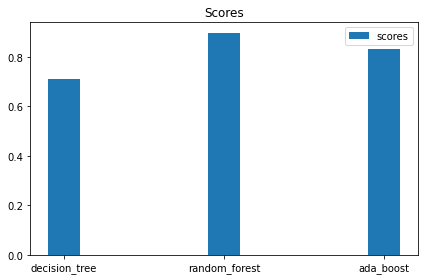

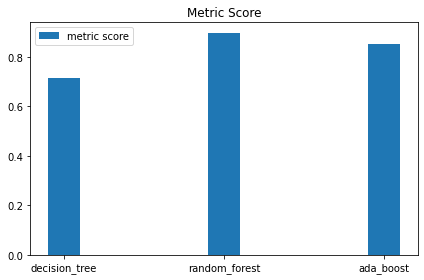

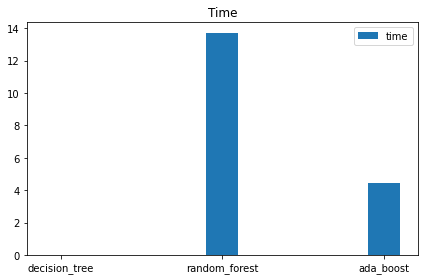

In [91]:
# Make plots here
ensemble_handler.plot_metric()

### Part 2 [15 points] 
This is an extension of HW4 problem on sentiment classification over reviews.

Here we make use DecisionTree ensembles to **classify** review as positive or negative

In [95]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import StratifiedKFold

In [96]:
reviews  = pd.read_csv('./data/reviews.csv')
train, test = train_test_split(reviews, test_size=0.2, random_state=4622)
X_train = train['reviews'].values
X_test = test['reviews'].values
y_train = train['sentiment']
y_test = test['sentiment']

#### Part 2 A [10 points]
Perform the following: 

* Create pipeline for `RandomForestClassifier` and `AdaBoostClassifier` as shown for `DecisionTreeClassifier` below. Refer to: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
* Fit the reviews dataset on the above models and report the results. (tune parameters of classifier for optimal performance)
* Use `n_estimators = 500` for both classifiers.

In [97]:
from sklearn.tree import DecisionTreeClassifier

# Define tokenizer.
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

# vectorizer 
en_stopwords = set(stopwords.words("english")) 
vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=tokenize,
    lowercase=True,
    ngram_range=(1, 2),
    stop_words=en_stopwords,
    min_df=10)


# create a handler for ensemble_test , 
# use the created handler for fitting different models.
ensemble_classifier_handler = EnsembleTest(
    X_train, y_train, X_test, y_test, _type='classification')


# Create a and fit pipeline for DecisionTreeClassifier.
pipeline_decision_tree = make_pipeline(
    vectorizer, DecisionTreeClassifier(random_state=0))
ensemble_classifier_handler.fit_model(
    pipeline_decision_tree,' decision tree classifier')
ensemble_classifier_handler.print_result()

                       Model  Mean accuracy score  Precision  Execution time
0   decision tree classifier                0.698   0.685824        5.854008


In [98]:
from sklearn.ensemble import RandomForestClassifier
# TODO: Create a and fit pipeline for RandomForestClassifier.
rand_forest_pipe = make_pipeline(
    vectorizer, RandomForestClassifier(n_estimators = 500, random_state=0))
ensemble_classifier_handler.fit_model(
    rand_forest_pipe,'random forest')
# ensemble_classifier_handler.print_result()

                       Model  Mean accuracy score  Precision  Execution time
1              random forest                0.854   0.843137       17.565141
0   decision tree classifier                0.698   0.685824        5.854008


In [99]:
from sklearn.ensemble import AdaBoostClassifier
# TODO: Create a and fit pipeline for AdaBoostClassifier
ada_boost_pipe = make_pipeline(
    vectorizer, AdaBoostClassifier(n_estimators=500, random_state=0))
ensemble_classifier_handler.fit_model(
    ada_boost_pipe,'ada boost')
# ensemble_classifier_handler.print_result()

                       Model  Mean accuracy score  Precision  Execution time
1              random forest                0.854   0.843137       17.565141
2                  ada boost                0.846   0.859244       14.724454
0   decision tree classifier                0.698   0.685824        5.854008


#### Part 2 B [5 points] Report results and make plots.

This should take one line each (one function call each on ensemble_handler)

In [100]:
# Report results here
ensemble_classifier_handler.print_result()

                       Model  Mean accuracy score  Precision  Execution time
1              random forest                0.854   0.843137       17.565141
2                  ada boost                0.846   0.859244       14.724454
0   decision tree classifier                0.698   0.685824        5.854008


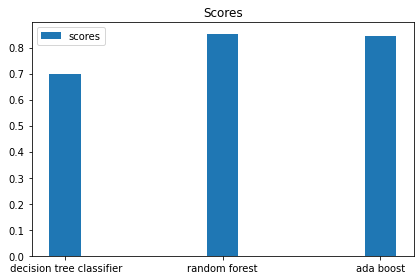

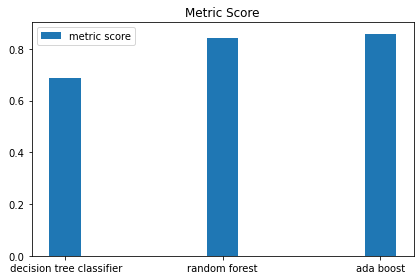

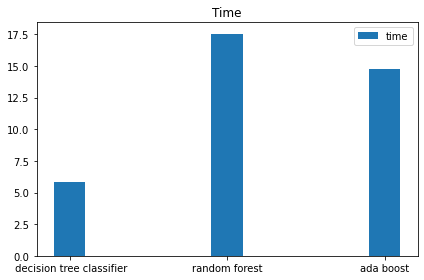

In [101]:
# Make plots here
# YOUR CODE HERE
ensemble_classifier_handler.plot_metric()

### Part 3 [10 points]
In the following space below discuss at least one advantage and disadvantage for *Random Forest* and *AdaBoost*.

RANDOM FOREST:
* Advantage - Is more robust against extra noise 
* Disadvantage - Takes much longer to run, more hyperparameter tuning

ADA BOOST:
* Advantage - Relatively quick (in comparison to random forest, not compared to decision tree classifier), not a lot of hyperparameter tuning.
* Disadvantage - Not particularly robust in handling data with a lot of noise, run time increases as complexity increases.